#### 1.1 Load the data.

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from matplotlib.dates import MonthLocator, DateFormatter
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
sns.set_style('whitegrid')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import warnings
warnings.filterwarnings("ignore")
import sklearn.linear_model as sk_linear
import sklearn.ensemble as sk_ens

In [3]:
#df = pd.read_csv('groupon.txt', sep=None, engine='python')
#df.to_parquet('groupon.parquet')

In [4]:
df = pd.read_parquet('groupon.parquet')

In [5]:
df.head()

,refund_bucket,refund_sub_bucket,order_date,transaction_date,week_end_date,dmm_subcat_1,category_1,deal_supply_channel,buyer_name_1,auth_bookings,capture_bookings,refunds,cancel_refunds,refunded_units,auth_refunds,capture_units
0,Other,Other,8/4/2016,8/4/2016,8/7/2016,Inverse Normal,Probability distribution II,Goods Stores,Asher,?,?,91.87,?,3,?,?
1,Returns,Change of mind,8/31/2018,9/21/2018,9/23/2018,Binomial Distribution.,Probability distribution I,Goods,Jesus,?,?,20.98,?,1,?,?
2,Fraud,Fraud,4/19/2017,4/19/2017,4/23/2017,Power series,Calculus II,Goods,Tristan,?,?,?,79.94,?,?,?
3,Two-Hour Refunds,Two-Hour Refunds,2/5/2016,2/5/2016,2/7/2016,Prime Factorization Algorithms,?,Goods,Jeremiah,?,?,49.267469958,?,1,?,?
4,Shortage Cancellations,Vendor Shortage,7/21/2018,8/15/2018,8/19/2018,Transformations,Geometry,Goods,Jacob,?,?,29.97,?,2,?,?


Our dataframe consists of 16 columns and approximately 6.8 millions rows. The dataframe is huge as it occupies almost 1 GB of memory. Python loaded all columns as objects - so we need to transform data into right data type. The original dictionary with data types description is provided below.

|Column_name	                |Type		|Description
| --- | --- | --- |
|refund_bucket                 	|Varchar	|Reason for refunding customer
|refund_sub_bucket             	|Varchar	|Sub reason for refunding customer
|transaction_date              	|Date		|date of refund
|week_end_date                 	|Date		|weekend date of refund
|dmm_subcat                    	|Varchar	|sub category of product
|category                      	|Varchar	|category of product
|deal_supply_channel           	|Varchar	|channel of sale
|buyer_name                    	|Varchar	|name of buyer who sourced the product
|auth_bookings                 	|Float		|bookings authorized on card
|capture_bookings              	|Float		|bookings captured
|refunds                       	|Float		|amount of refund
|cancel_refunds                	|Float		|refunds if the transaction was a cancellation
|refunded_units                	|Integer	|quantity of product for which refunds were issued
|auth_refunds                  	|Integer	|	
|capture_units                 	|Integer	|	

To allow a faster processing and easy data manipulation let's subset our dataframe to separate one year of transactions and refunds based on a transaction date. I will take 2018 data. 

To do so I need to convert all date's columns to Python date-time format and will use a boolean mask to create a subset.

In [6]:
df['order_date'] = pd.to_datetime(df['order_date'], infer_datetime_format=True)
df['transaction_date'] = pd.to_datetime(df['transaction_date'], infer_datetime_format=True)
df['week_end_date'] = pd.to_datetime(df['week_end_date'], infer_datetime_format=True)

Since I have already converted date's columns to date format, I can set a desired date to filter a dataframe. Then I will assign a mask to dateaframe.

In [7]:
start_date = '2018-01-01'
end_date = '2018-12-31'
mask = (df['transaction_date'] >= start_date) & (df['transaction_date'] <= end_date)
subset = df.loc[mask]
subset.shape

(2162199, 16)

In [8]:
subset = subset.copy()

In [9]:
subset.columns

Index(['refund_bucket', 'refund_sub_bucket', 'order_date', 'transaction_date',
       'week_end_date', 'dmm_subcat_1', 'category_1', 'deal_supply_channel',
       'buyer_name_1', 'auth_bookings', 'capture_bookings', 'refunds',
       'cancel_refunds', 'refunded_units', 'auth_refunds', 'capture_units'],
      dtype='object')

In [10]:
subset.drop(['refund_bucket', 'refund_sub_bucket', 'order_date', 'week_end_date', 
             'dmm_subcat_1', 'category_1', 'deal_supply_channel','buyer_name_1', 
             'auth_bookings','cancel_refunds', 'refunded_units', 'auth_refunds', 
             'capture_units'], axis = 1, inplace = True)

Now let's convert capture_bookings into the float data type.

In [11]:
subset['capture_bookings'] = subset['capture_bookings'].str.replace('?', '0').astype(float)
subset['refunds'] = subset['refunds'].str.replace('?', '0').astype(float)

Let's create year, month, and day columns to plot refund and transaction amounts

In [12]:
variable = pd.DatetimeIndex(subset['transaction_date'])
subset['year'],subset['month'],subset['day'] = variable.year, variable.month, variable.day

In [13]:
avg_data = subset.groupby(['month','day']).agg({'refunds':np.mean,'capture_bookings':np.mean})
avg_data.index = [datetime(2018,month,day) for (month, day) in avg_data.index]

<Figure size 432x288 with 0 Axes>

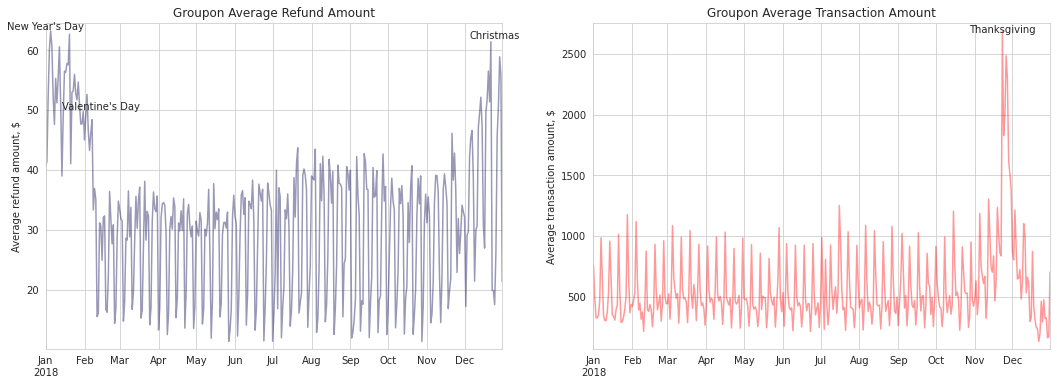

In [14]:
plt.figure()
plt.figure(figsize=(18,6))

# subplot 1
plt.subplot(1,2,1)
avg_data['refunds'].plot(colormap='seismic',alpha=0.4)
plt.text('2018-12-25',62,'Christmas',ha='center')
plt.text('2018-01-01',63.5,"New Year's Day",ha='center')
plt.text('2018-02-14',50,"Valentine's Day",ha='center')
plt.ylabel('Average refund amount, $')
plt.title(r'Groupon Average Refund Amount')
plt.margins(0.010, 0.025)

# subplot 2
plt.subplot(1,2,2)
avg_data['capture_bookings'].plot(colormap='autumn', alpha=0.4)
plt.text('2018-11-23',2675,'Thanksgiving',ha='center')
plt.ylabel('Average transaction amount, $')
plt.title(r'Groupon Average Transaction Amount')
plt.margins(0.010, 0.025)
plt.show()

From the following plots, we can clearly see that refunds and transactions have spikes and valleys. A clear seasnal trend can be detected here. We can observe the biggest transaction spike during Thanksgiving, when most people shop for Christmas gifts. We can also observe the highest amount of refunds during Christmas, New Year's, and Valentine's Day, when people return gifts they didn't like.

In [15]:
refunds_df = df[['transaction_date', 'refunds']]
refunds_df['refunds'] = refunds_df['refunds'].str.replace('?', '0').astype(float)
refunds_df = refunds_df.resample('D', on='transaction_date').mean()
print(refunds_df.shape)
refunds_df.head()

(1186, 1)


,refunds
transaction_date,
2016-01-01,86.29
2016-01-02,83.79
2016-01-03,72.15
2016-01-04,67.73
2016-01-05,82.10


In [16]:
# I choose 365 because there is 365 days in a year
refunds_df["type"] = "train"
refunds_df.tail(365)["type"] = "test"
refunds_df.iloc[818:824, :]

,refunds,type
transaction_date,,
2018-03-29,33.56,train
2018-03-30,33.07,train
2018-03-31,35.70,train
2018-04-01,13.34,test
2018-04-02,17.07,test
2018-04-03,31.92,test


<AxesSubplot:xlabel='transaction_date'>

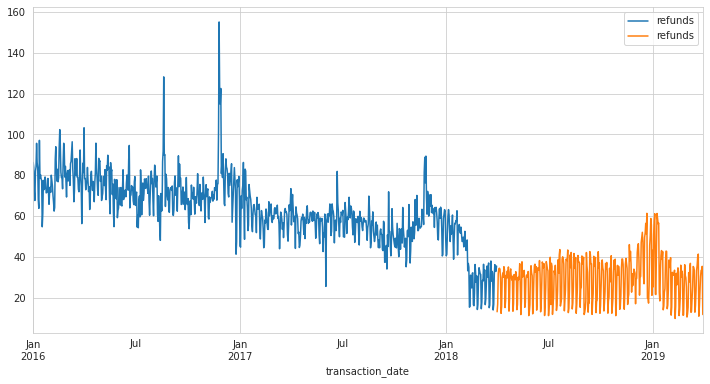

In [17]:
train = refunds_df[refunds_df["type"]=="train"]
test = refunds_df[refunds_df["type"]=="test"]

ax = train.plot(figsize = (12,6))
test.plot(ax = ax)

In [18]:
train.reset_index(level = 0, inplace = True)
test.reset_index(level = 0, inplace = True)
test.index = test.index + 821

In [19]:
new_dataset = pd.concat([train, pd.DataFrame({"transaction_date": test["transaction_date"], "type": "test"})])
new_dataset

,transaction_date,refunds,type
0,2016-01-01,86.29,train
1,2016-01-02,83.79,train
2,2016-01-03,72.15,train
3,2016-01-04,67.73,train
4,2016-01-05,82.10,train
...,...,...,...
1181,2019-03-27,nan,test
1182,2019-03-28,nan,test
1183,2019-03-29,nan,test
1184,2019-03-30,nan,test


In [20]:
from statsmodels.tsa.stattools import adfuller
import copy
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    Augmented Dickey-Fuller Test: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [21]:
# checking if the data is stationary
adf_check(new_dataset[new_dataset["type"]=='train']["refunds"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -0.9440889214938666
p-value : 0.7731069338840706
Number of Lags Used : 21
Number of Observations Used : 799
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 



<AxesSubplot:>

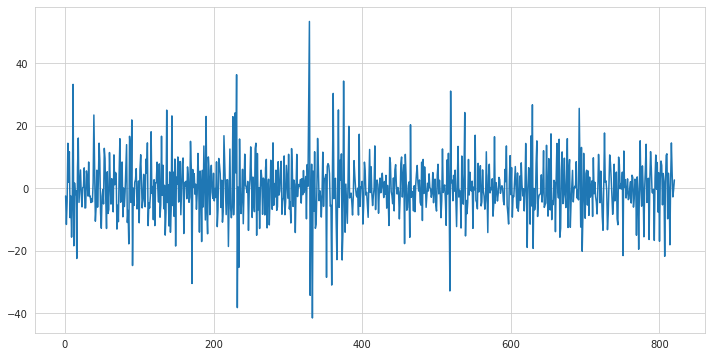

In [22]:
# how to describe this? It looks pretty good to me because it centered exactly at zero. Am I correct?
new_dataset[new_dataset["type"]=='train']["refunds"].diff().plot(figsize = (12,6))

In [23]:
new_dataset[new_dataset["type"]=='train']["refunds"].diff().cumsum()

0        nan
1      -2.49
2     -14.13
3     -18.56
4      -4.18
       ...  
816   -54.81
817   -49.92
818   -52.73
819   -53.22
820   -50.59
Name: refunds, Length: 821, dtype: float64

In [24]:
new_dataset[new_dataset["type"]=='train']["refunds"]

0     86.29
1     83.79
2     72.15
3     67.73
4     82.10
       ... 
816   31.47
817   36.37
818   33.56
819   33.07
820   35.70
Name: refunds, Length: 821, dtype: float64

In [25]:
new_dataset[new_dataset["type"]=='train']["refunds"].diff().dropna()

1      -2.49
2     -11.64
3      -4.43
4      14.38
5       1.90
       ...  
816    14.49
817     4.90
818    -2.81
819    -0.49
820     2.63
Name: refunds, Length: 820, dtype: float64

In [26]:
# making the data stationary - I added diff() only one time and it made the data stationary 
adf_check(new_dataset[new_dataset["type"]=='train']["refunds"].diff().dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -8.536830778418977
p-value : 1.0027253823375694e-13
Number of Lags Used : 20
Number of Observations Used : 799
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [27]:
new_dataset["refunds_diff_1"] = new_dataset["refunds"].diff()
new_dataset

,transaction_date,refunds,type,refunds_diff_1
0,2016-01-01,86.29,train,nan
1,2016-01-02,83.79,train,-2.49
2,2016-01-03,72.15,train,-11.64
3,2016-01-04,67.73,train,-4.43
4,2016-01-05,82.10,train,14.38
...,...,...,...,...
1181,2019-03-27,nan,test,nan
1182,2019-03-28,nan,test,nan
1183,2019-03-29,nan,test,nan
1184,2019-03-30,nan,test,nan


In [28]:
new_dataset["Value"] = new_dataset["refunds_diff_1"]

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
def AR(p,df, starting_lag=0):
    df_temp = df

    #Generating the lagged p terms
    for i in range(starting_lag+1,starting_lag+p+1,1):
        df_temp['Shifted_values_%d' % i ] = df_temp['Value'].shift(i)

    train_size = (int)(0.8 * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()
    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)
    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    #Running linear regression to generate the coefficents of lagged terms
    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Value'] = X_train.dot(lr.coef_.T) + lr.intercept_
    # df_train_2[['Value','Predicted_Values']].plot()

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Value'] = X_test.dot(lr.coef_.T) + lr.intercept_
    # df_test[['Value','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Value']))

#     print("The RMSE is :", RMSE,", Value of p : ",p)
    
    return [df_train_2,df_test,theta,intercept,RMSE]

for i in range(1,37,1):
    _,_,_,_, rmse = AR(i, new_dataset[["Value"]].dropna(), 23)
    print(f"Number of lags: {i}, RMSE: {rmse}")

Number of lags: 1, RMSE: 8.38839785865636
Number of lags: 2, RMSE: 8.39261811494903
Number of lags: 3, RMSE: 8.32871725281702
Number of lags: 4, RMSE: 8.348163728849189
Number of lags: 5, RMSE: 8.028755966389536
Number of lags: 6, RMSE: 8.047490416164651
Number of lags: 7, RMSE: 8.109327841172272
Number of lags: 8, RMSE: 8.097938237920976
Number of lags: 9, RMSE: 8.105889236436724
Number of lags: 10, RMSE: 8.100146996774955
Number of lags: 11, RMSE: 8.10495121965165
Number of lags: 12, RMSE: 8.046660817652935
Number of lags: 13, RMSE: 8.014455370057016
Number of lags: 14, RMSE: 8.005046588337212
Number of lags: 15, RMSE: 7.969210705170281
Number of lags: 16, RMSE: 7.97168937624984
Number of lags: 17, RMSE: 7.9698168237236064
Number of lags: 18, RMSE: 7.970054720153517
Number of lags: 19, RMSE: 8.00483736488105
Number of lags: 20, RMSE: 8.012956552231639
Number of lags: 21, RMSE: 8.039973389657542
Number of lags: 22, RMSE: 8.032177869664535
Number of lags: 23, RMSE: 8.036250865751073
Nu

In [30]:
# my RMSE is pretty low. That is very good but WHY??
# is it ok to choose 364 as a lag_shift because there is 365 days in a year?
lag_shift = 364
lags = 15

col2use = []
for i in range(lag_shift+1,lag_shift+lags+1,1):
    new_dataset['Shifted_values_%d' % i ] = new_dataset['Value'].shift(i) 
    col2use.append('Shifted_values_%d' % i)
    

In [31]:
new_dataset

,transaction_date,refunds,type,refunds_diff_1,Value,Shifted_values_365,Shifted_values_366,Shifted_values_367,Shifted_values_368,Shifted_values_369,Shifted_values_370,Shifted_values_371,Shifted_values_372,Shifted_values_373,Shifted_values_374,Shifted_values_375,Shifted_values_376,Shifted_values_377,Shifted_values_378,Shifted_values_379
0,2016-01-01,86.29,train,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2016-01-02,83.79,train,-2.49,-2.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2016-01-03,72.15,train,-11.64,-11.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2016-01-04,67.73,train,-4.43,-4.43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2016-01-05,82.10,train,14.38,14.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,2019-03-27,nan,test,nan,nan,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69
1182,2019-03-28,nan,test,nan,nan,4.90,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29
1183,2019-03-29,nan,test,nan,nan,-2.81,4.90,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34
1184,2019-03-30,nan,test,nan,nan,-0.49,-2.81,4.90,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71


In [42]:
X_train = new_dataset[new_dataset["type"]=='train'][col2use+["Value"]].dropna()
X_test =  new_dataset[new_dataset["type"]=='test'][col2use].values
lr = LinearRegression()
# lr = sk_ens.ExtraTreesRegressor()
lr.fit(X_train[col2use].values, X_train["Value"].values)

LinearRegression()

In [43]:
preds = lr.predict(X_test)

In [44]:
new_dataset.loc[new_dataset["type"]=='test',"Value"] = preds
new_dataset.loc[new_dataset["type"]=='test',"refunds_diff_1"] = new_dataset.loc[new_dataset["type"]=='test',"Value"]

In [45]:
new_dataset.tail(12)

,transaction_date,refunds,type,refunds_diff_1,Value,Shifted_values_365,Shifted_values_366,Shifted_values_367,Shifted_values_368,Shifted_values_369,Shifted_values_370,Shifted_values_371,Shifted_values_372,Shifted_values_373,Shifted_values_374,Shifted_values_375,Shifted_values_376,Shifted_values_377,Shifted_values_378,Shifted_values_379
1174,2019-03-20,37.91,test,3.09,3.09,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62
1175,2019-03-21,39.55,test,0.30,0.30,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33
1176,2019-03-22,38.60,test,1.75,1.75,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21
1177,2019-03-23,37.42,test,-2.67,-2.67,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67
1178,2019-03-24,31.89,test,-5.25,-5.25,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93
1179,2019-03-25,29.96,test,-0.27,-0.27,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02
1180,2019-03-26,34.32,test,3.99,3.99,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69,2.88
1181,2019-03-27,33.91,test,2.67,2.67,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29,8.69
1182,2019-03-28,33.59,test,-1.19,-1.19,4.90,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34,7.29
1183,2019-03-29,33.21,test,2.22,2.22,-2.81,4.90,14.49,2.79,-18.16,-0.76,4.78,-9.82,11.01,10.55,1.28,-21.85,2.16,4.71,-5.34


In [46]:
new_dataset.head()

,transaction_date,refunds,type,refunds_diff_1,Value,Shifted_values_365,Shifted_values_366,Shifted_values_367,Shifted_values_368,Shifted_values_369,Shifted_values_370,Shifted_values_371,Shifted_values_372,Shifted_values_373,Shifted_values_374,Shifted_values_375,Shifted_values_376,Shifted_values_377,Shifted_values_378,Shifted_values_379
0,2016-01-01,86.29,train,86.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2016-01-02,83.79,train,-2.49,-2.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2016-01-03,72.15,train,-11.64,-11.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2016-01-04,67.73,train,-4.43,-4.43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2016-01-05,82.10,train,14.38,14.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [47]:
new_dataset.loc[0,"refunds_diff_1"] = new_dataset.loc[0,"refunds"]
new_dataset.head(6)

,transaction_date,refunds,type,refunds_diff_1,Value,Shifted_values_365,Shifted_values_366,Shifted_values_367,Shifted_values_368,Shifted_values_369,Shifted_values_370,Shifted_values_371,Shifted_values_372,Shifted_values_373,Shifted_values_374,Shifted_values_375,Shifted_values_376,Shifted_values_377,Shifted_values_378,Shifted_values_379
0,2016-01-01,86.29,train,86.29,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,2016-01-02,83.79,train,-2.49,-2.49,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2016-01-03,72.15,train,-11.64,-11.64,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,2016-01-04,67.73,train,-4.43,-4.43,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,2016-01-05,82.10,train,14.38,14.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,2016-01-06,84.01,train,1.90,1.90,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [48]:
new_dataset.loc[new_dataset["type"]=='test',"refunds"] = new_dataset["refunds_diff_1"].cumsum()[new_dataset["type"]=='test']

In [49]:
new_dataset.tail(24)

,transaction_date,refunds,type,refunds_diff_1,Value,Shifted_values_365,Shifted_values_366,Shifted_values_367,Shifted_values_368,Shifted_values_369,Shifted_values_370,Shifted_values_371,Shifted_values_372,Shifted_values_373,Shifted_values_374,Shifted_values_375,Shifted_values_376,Shifted_values_377,Shifted_values_378,Shifted_values_379
1162,2019-03-08,24.32,test,0.04,0.04,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70,2.44,-16.45,3.17,-4.14,-4.59
1163,2019-03-09,22.70,test,-1.62,-1.62,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70,2.44,-16.45,3.17,-4.14
1164,2019-03-10,16.19,test,-6.51,-6.51,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70,2.44,-16.45,3.17
1165,2019-03-11,17.57,test,1.38,1.38,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70,2.44,-16.45
1166,2019-03-12,19.54,test,1.97,1.97,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70,2.44
1167,2019-03-13,23.24,test,3.70,3.70,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29,11.70
1168,2019-03-14,22.91,test,-0.33,-0.33,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36,6.29
1169,2019-03-15,23.93,test,1.03,1.03,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58,-1.36
1170,2019-03-16,21.24,test,-2.70,-2.70,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37,-1.58
1171,2019-03-17,15.55,test,-5.69,-5.69,2.16,4.71,-5.34,7.29,8.69,2.88,-17.02,4.93,-7.67,8.21,-0.33,10.62,3.24,-16.75,-0.37


<AxesSubplot:>

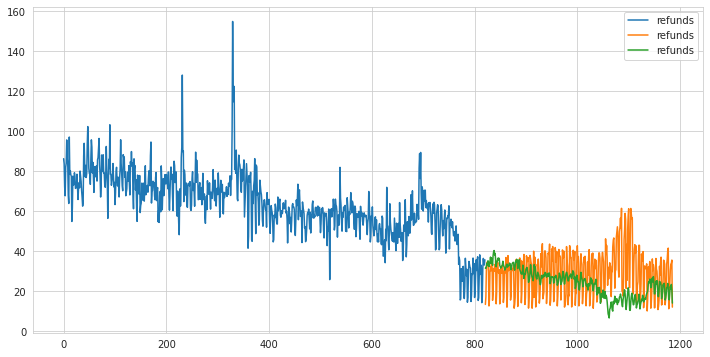

In [50]:
ax = new_dataset[new_dataset["type"]=="train"][["refunds"]].plot(figsize = (12,6))
test[["refunds"]].plot(ax = ax)
new_dataset[new_dataset["type"]=="test"][["refunds"]].plot(ax = ax)

As we can see our predictions (green line) is a little bit higher than the actual amount of refunds (yellow) for the same period of time. However, the `ExtraTreeRegressor()` correctly predicted the spike in refunds around Christmas time but was not as good in catching downward trend. To the contrary, `LinearRegression()` catches downward trend perfectly but fails to catch a Christmas time spike. Our RMSE = 24.15 for `ExtraTreeRegressor()` and RMSE = 14.45 for `LinearRegression()`. 

In [41]:
print(f'RMSE: {np.sqrt(mean_squared_error(test["refunds"], new_dataset[new_dataset["type"]=="test"]["refunds"]))}')

RMSE: 28.55799981349009
